**Imports**

In [340]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.subplots as sp
from plotly.subplots import make_subplots
import plotly.express as px
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error 
import os
from keras import layers
from keras import Sequential
from keras.callbacks import EarlyStopping
import tensorflow as tf

In [341]:
cuda_version = os.popen('nvcc --version').read()
print(cuda_version)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:41:10_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0



In [342]:
from tensorflow.python.keras import backend as K
print(K._get_available_gpus())

[]


Bon ben pas de GPU pour keras

In [343]:
import random
import os

np.random.seed(2025)
random.seed(2025)



In [344]:
data_test = pd.read_csv('data/test.csv')
data_train = pd.read_csv('data/train.csv')

data_train.set_index(data_train.id , inplace=True)
data_train.drop(columns='id' , axis=1, inplace = True)
data_test.set_index(data_test.id , inplace=True)
data_test.drop(columns='id' , axis=1, inplace = True)
print(data_train.shape,data_test.shape)
print(data_train.columns)
data_train

(300000, 10) (200000, 9)
Index(['Brand', 'Material', 'Size', 'Compartments', 'Laptop Compartment',
       'Waterproof', 'Style', 'Color', 'Weight Capacity (kg)', 'Price'],
      dtype='object')


,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
id,,,,,,,,,,
0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312
...,...,...,...,...,...,...,...,...,...,...
299995,Adidas,Leather,Small,9.0,No,No,Tote,Blue,12.730812,129.99749
299996,Jansport,Leather,Large,6.0,No,Yes,Tote,Blue,26.633182,19.85819
299997,Puma,Canvas,Large,9.0,Yes,Yes,Backpack,Pink,11.898250,111.41364


## *Basic Analysis Dataframe*

In [345]:
data_train.head()

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
id,,,,,,,,,,
0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


In [346]:
data_test.describe()

,Compartments,Weight Capacity (kg)
count,200000.000000,199923.000000
mean,5.442855,17.993033
std,2.888740,6.972079
min,1.000000,5.000000
25%,3.000000,12.068875
50%,5.000000,18.054750
75%,8.000000,23.965700
max,10.000000,30.000000


In [347]:
data_train.describe()

,Compartments,Weight Capacity (kg),Price
count,300000.000000,299862.000000,300000.000000
mean,5.443590,18.029994,81.411107
std,2.890766,6.966914,39.039340
min,1.000000,5.000000,15.000000
25%,3.000000,12.097867,47.384620
50%,5.000000,18.068614,80.956120
75%,8.000000,24.002375,115.018160
max,10.000000,30.000000,150.000000


In [348]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 300000 entries, 0 to 299999
Data columns (total 10 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Brand                 290295 non-null  object 
 1   Material              291653 non-null  object 
 2   Size                  293405 non-null  object 
 3   Compartments          300000 non-null  float64
 4   Laptop Compartment    292556 non-null  object 
 5   Waterproof            292950 non-null  object 
 6   Style                 292030 non-null  object 
 7   Color                 290050 non-null  object 
 8   Weight Capacity (kg)  299862 non-null  float64
 9   Price                 300000 non-null  float64
dtypes: float64(3), object(7)
memory usage: 25.2+ MB


***On calcule ici Le % de Data manquante***

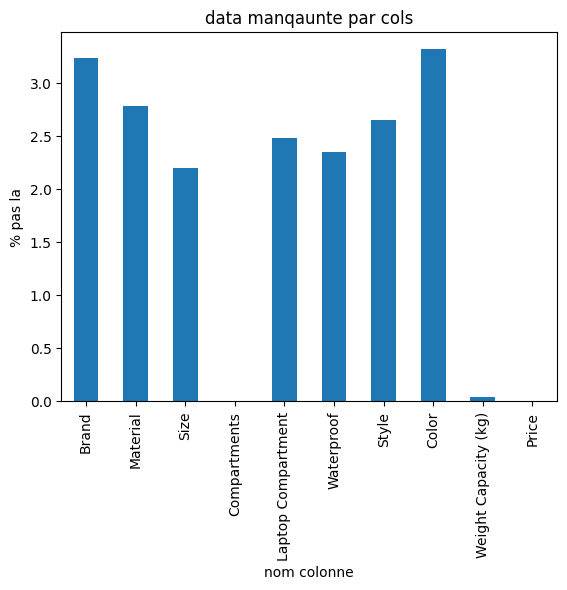

In [349]:
missing_ptage = (data_train.isnull().sum()/data_train.shape[0])*100
missing_ptage.plot(kind='bar')
plt.title('data manqaunte par cols')
plt.xlabel('nom colonne')
plt.ylabel('% pas la')
plt.show()

# **Data Cleaning + Data Analysis**

**On cherche a savoir si le Datasets est desequilibre dans ces categrorie et donc si on entraine le modele dessus y aura t'il un biais**

On cherche a savoir piur chaque colopnne si ya un desequilibre et quel data  sont les plus presente piur trouver des probleme /corelation et creer possiblement des nouvelles colonnes adapte

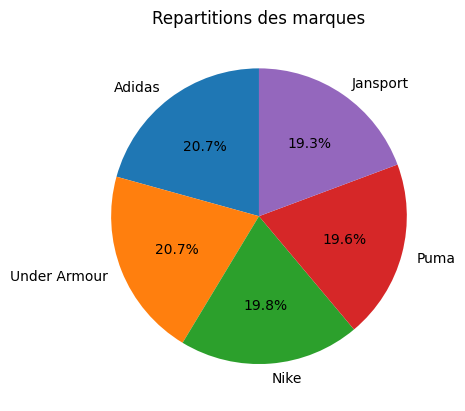

In [350]:
brand_counts = data_train['Brand'].value_counts()

plt.pie(brand_counts, labels=brand_counts.index, autopct='%1.1f%%', startangle=90)
plt.title("Repartitions des marques")
plt.show()

Les Marques sont quasi Even donc peut interet d'extrapoler

Meme chose poiur les materiels

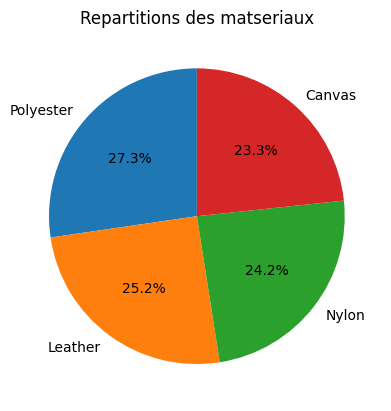

In [351]:
brand_counts = data_train['Material'].value_counts()

plt.pie(brand_counts, labels=brand_counts.index, autopct='%1.1f%%', startangle=90)
plt.title("Repartitions des matseriaux")

plt.show()

Even aussi

On continue pour le reste du dataframe

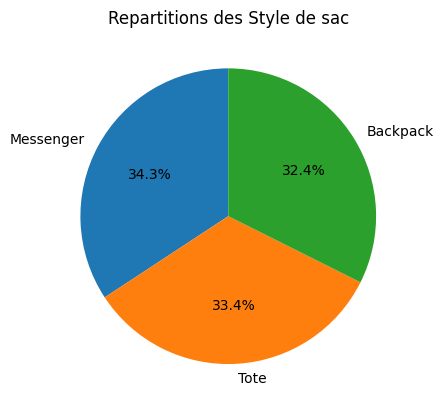

In [352]:
brand_counts = data_train['Style'].value_counts()

plt.pie(brand_counts, labels=brand_counts.index, autopct='%1.1f%%', startangle=90)
plt.title("Repartitions des Style de sac")
plt.show()

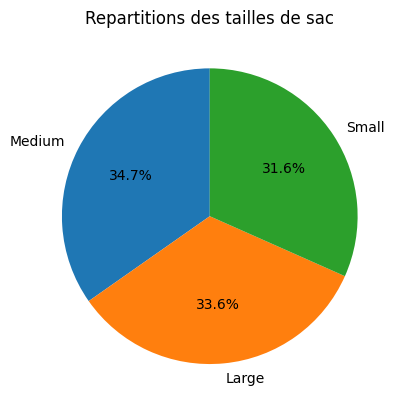

In [353]:
brand_counts = data_train['Size'].value_counts()

plt.pie(brand_counts, labels=brand_counts.index, autopct='%1.1f%%', startangle=90)
plt.title("Repartitions des tailles de sac")
plt.show()

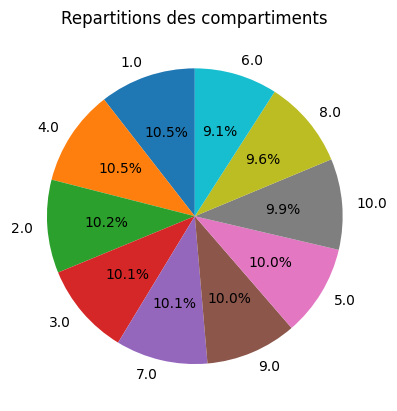

In [354]:
brand_counts = data_train['Compartments'].value_counts()

plt.pie(brand_counts, labels=brand_counts.index, autopct='%1.1f%%', startangle=90)
plt.title("Repartitions des compartiments")

plt.show()

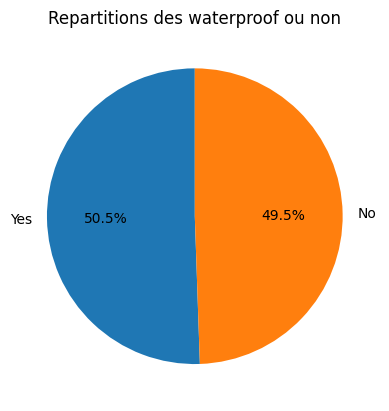

In [355]:
brand_counts = data_train['Waterproof'].value_counts()

plt.pie(brand_counts, labels=brand_counts.index, autopct='%1.1f%%', startangle=90)
plt.title("Repartitions des waterproof ou non")

plt.show()

In [356]:
data_train.columns

Index(['Brand', 'Material', 'Size', 'Compartments', 'Laptop Compartment',
       'Waterproof', 'Style', 'Color', 'Weight Capacity (kg)', 'Price'],
      dtype='object')

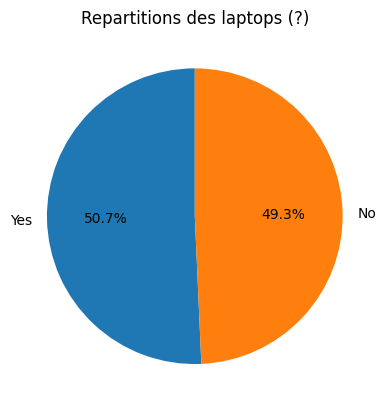

In [357]:
brand_counts = data_train['Laptop Compartment'].value_counts()

plt.pie(brand_counts, labels=brand_counts.index, autopct='%1.1f%%', startangle=90)
plt.title("Repartitions des laptops (?)")

plt.show()

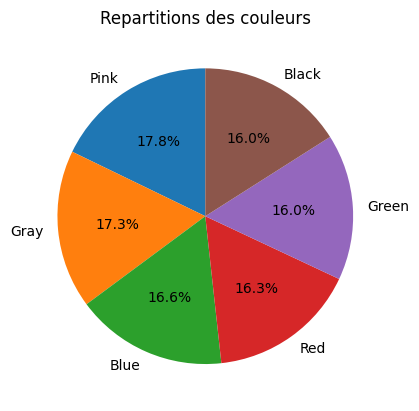

In [358]:
brand_counts = data_train['Color'].value_counts()

plt.pie(brand_counts, labels=brand_counts.index, autopct='%1.1f%%', startangle=90)
plt.title("Repartitions des couleurs")

plt.show()

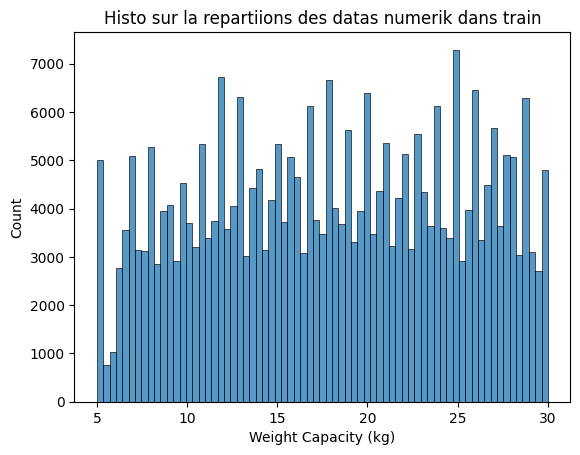

In [359]:
sns.histplot(data_train['Weight Capacity (kg)'])
plt.title('Histo sur la repartiions des datas numerik dans train')
plt.show()

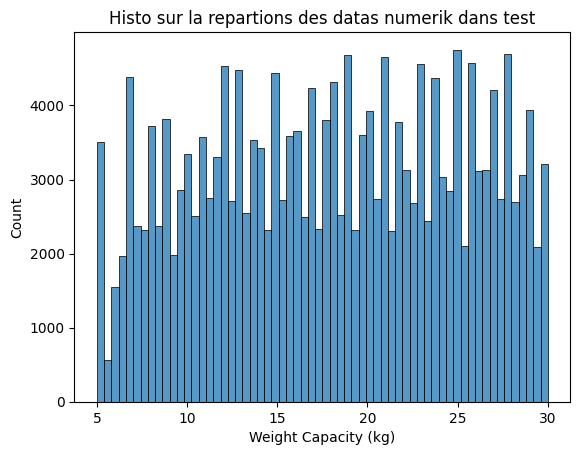

In [360]:
sns.histplot(data_test['Weight Capacity (kg)'])
plt.title('Histo sur la repartions des datas numerik dans test')

plt.show()

### **Le datasets est Bon on a des pas de datas Trop proeminente face aux Autres donc pas de modifs a faire afin de rectifier cela**

On passe au data cleaning et preprocessing

On divise les colonne en 2 categorie les categorical et les numeriques pour eviter des problemes de gestions de data

Je rename parce que le nom de la cols est chiant

In [361]:

data_train.rename(columns={'Weight Capacity (kg)': 'wCap'}, inplace=True)
data_test.rename(columns={'Weight Capacity (kg)': 'wCap'}, inplace=True)

In [362]:
data_train.columns

Index(['Brand', 'Material', 'Size', 'Compartments', 'Laptop Compartment',
       'Waterproof', 'Style', 'Color', 'wCap', 'Price'],
      dtype='object')

In [363]:
colsCategoriacal =["Brand", "Material", "Size", "Laptop Compartment", "Waterproof", "Style", "Color"]

colsNumerik = ["wCap"] # On ne normlise pas la target donc j'exclut ici

On com par les nums cols

Pas lineaire donc on supprime interpolate dans la facon de fill la data donc je vais aller sur la moyenne qui presenbte moi d'inconvenient au vu du graph

In [364]:
#On fill avec une valeur moyenne
"""data_train["wCap"].fillna(data_train["wCap"].median(), inplace=True)
data_test["wCap"].fillna(data_test["wCap"].median(), inplace=True)"""


data_train.loc[:, "wCap"] = data_train["wCap"].fillna(data_train["wCap"].median())
data_test.loc[:, "wCap"] = data_test["wCap"].fillna(data_test["wCap"].median())


In [365]:
print(data_train["wCap"].isna().sum() , data_test["wCap"].isna().sum())

0 0


In [366]:
data_train.dtypes

Brand                  object
Material               object
Size                   object
Compartments          float64
Laptop Compartment     object
Waterproof             object
Style                  object
Color                  object
wCap                  float64
Price                 float64
dtype: object

Num cols done => on passe au cat

In [367]:
for cols in colsCategoriacal:
    data_train[cols] = data_train[cols].fillna(data_train[cols].mode()[0])
    data_test[cols] = data_test[cols].fillna(data_test[cols].mode()[0])

print(data_train.isna().sum() , data_test.isna().sum() )

Brand                 0
Material              0
Size                  0
Compartments          0
Laptop Compartment    0
Waterproof            0
Style                 0
Color                 0
wCap                  0
Price                 0
dtype: int64 Brand                 0
Material              0
Size                  0
Compartments          0
Laptop Compartment    0
Waterproof            0
Style                 0
Color                 0
wCap                  0
dtype: int64


data Clean ! on a plus de valeur manquante.

# **3 - Data preprocessing**


Je voulais faire pipeline classique avec Standard Scaler sauf que => categical Data donc on fais autre chose pour les cat colonnes


Donc Standard scaler pour col numerique
et LabelEncoder pour les cat

In [368]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

label_encoder = LabelEncoder()
scaler = StandardScaler()

for col in colsCategoriacal:
    data_train[col] = label_encoder.fit_transform(data_train[col])
    data_test[col] = label_encoder.transform(data_test[col])  

data_train[colsNumerik] = scaler.fit_transform(data_train[colsNumerik])
data_test[colsNumerik] = scaler.transform(data_test[colsNumerik])  

print(data_train.head())
print(data_test.head())

    Brand  Material  Size  Compartments  Laptop Compartment  Waterproof  \
id                                                                        
0       1         1     1           7.0                   1           0   
1       1         0     2          10.0                   1           1   
2       4         1     2           2.0                   1           0   
3       2         2     2           8.0                   1           0   
4       0         0     1           1.0                   1           1   

    Style  Color      wCap      Price  
id                                     
0       2      0 -0.921466  112.15875  
1       1      3  1.299086   68.88056  
2       1      5 -0.199023   39.17320  
3       1      3 -0.731166   80.60793  
4       1      3 -0.040296   86.02312  
        Brand  Material  Size  Compartments  Laptop Compartment  Waterproof  \
id                                                                            
300000      3         1     2       

In [369]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 300000 entries, 0 to 299999
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Brand               300000 non-null  int32  
 1   Material            300000 non-null  int32  
 2   Size                300000 non-null  int32  
 3   Compartments        300000 non-null  float64
 4   Laptop Compartment  300000 non-null  int32  
 5   Waterproof          300000 non-null  int32  
 6   Style               300000 non-null  int32  
 7   Color               300000 non-null  int32  
 8   wCap                300000 non-null  float64
 9   Price               300000 non-null  float64
dtypes: float64(3), int32(7)
memory usage: 17.2 MB


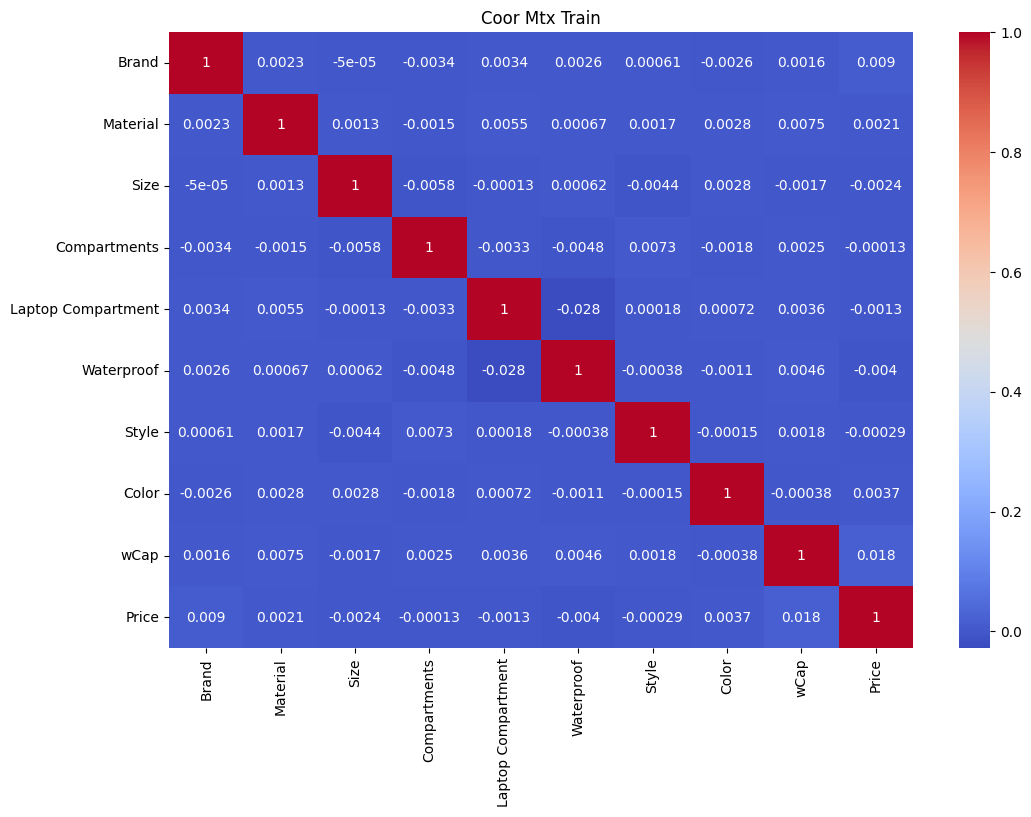

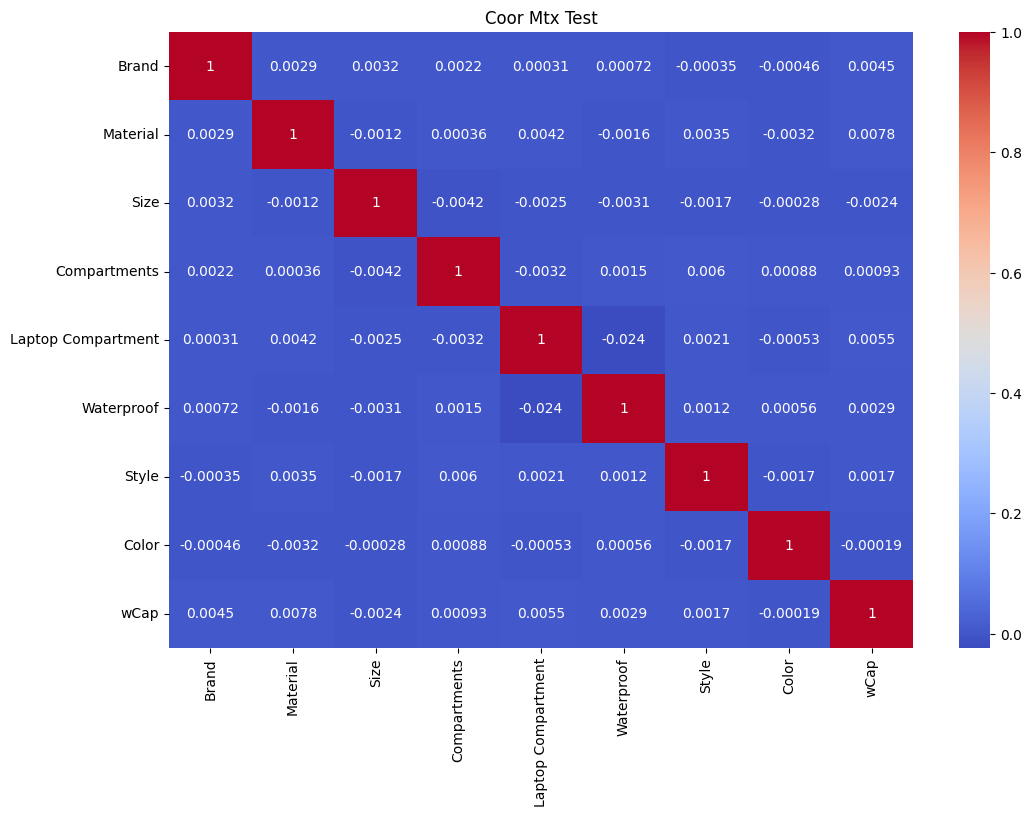

In [370]:
corr_matrix_train = data_train.corr()
corr_matrix_test = data_test.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_train, annot=True, cmap='coolwarm')
plt.title('Coor Mtx Train')
plt.show()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_test, annot=True, cmap='coolwarm')
plt.title('Coor Mtx Test')
plt.show()

In [371]:
data_test

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,wCap
id,,,,,,,,,
300000,3,1,2,2.0,0,0,2,3,0.379185
300001,2,0,1,7.0,0,1,0,3,-0.641165
300002,0,0,0,9.0,0,1,1,1,-0.893029
300003,0,2,0,1.0,1,0,1,3,0.064179
300004,0,2,0,2.0,1,1,2,0,-1.166074
...,...,...,...,...,...,...,...,...,...
499995,0,0,0,2.0,1,0,1,5,-1.528508
499996,2,3,2,9.0,0,1,1,4,-1.718751
499997,1,2,2,9.0,0,1,2,3,1.272042


# On supprime les cols ayu vu du results du 1 er Feature importance

In [372]:
# data_train = data_train.drop(columns=['Brand', 'Waterproof', 'wCap' , 'Laptop Compartment'], axis=1)
# data_test = data_test.drop(columns=['Brand', 'Waterproof', 'wCap','Laptop Compartment'], axis=1)

data_train

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,wCap,Price
id,,,,,,,,,,
0,1,1,1,7.0,1,0,2,0,-0.921466,112.15875
1,1,0,2,10.0,1,1,1,3,1.299086,68.88056
2,4,1,2,2.0,1,0,1,5,-0.199023,39.17320
3,2,2,2,8.0,1,0,1,3,-0.731166,80.60793
4,0,0,1,1.0,1,1,1,3,-0.040296,86.02312
...,...,...,...,...,...,...,...,...,...,...
299995,0,1,2,9.0,0,0,2,1,-0.760800,129.99749
299996,1,1,0,6.0,0,1,2,1,1.235147,19.85819
299997,3,0,0,9.0,1,1,0,4,-0.880330,111.41364


In [373]:
X = data_train.drop(columns=['Price'], axis = 1)
X

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,wCap
id,,,,,,,,,
0,1,1,1,7.0,1,0,2,0,-0.921466
1,1,0,2,10.0,1,1,1,3,1.299086
2,4,1,2,2.0,1,0,1,5,-0.199023
3,2,2,2,8.0,1,0,1,3,-0.731166
4,0,0,1,1.0,1,1,1,3,-0.040296
...,...,...,...,...,...,...,...,...,...
299995,0,1,2,9.0,0,0,2,1,-0.760800
299996,1,1,0,6.0,0,1,2,1,1.235147
299997,3,0,0,9.0,1,1,0,4,-0.880330


In [374]:
Y = data_train['Price']
Y


id
0         112.15875
1          68.88056
2          39.17320
3          80.60793
4          86.02312
            ...    
299995    129.99749
299996     19.85819
299997    111.41364
299998    115.89080
299999     26.72762
Name: Price, Length: 300000, dtype: float64

In [375]:
X_train, X_val, y_train, y_val = train_test_split(X,Y,test_size=0.20,random_state=42)
print((X_train.dtypes))

Brand                   int32
Material                int32
Size                    int32
Compartments          float64
Laptop Compartment      int32
Waterproof              int32
Style                   int32
Color                   int32
wCap                  float64
dtype: object


# **4 - Modeles**

### On cherche le meilleur modele on prendra Model + early stopping 

2 options :
- MLP Regressor 
- CNN 



MLP Regressor


In [376]:
tf.random.set_seed(2025)

In [377]:
X_train

,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,wCap
id,,,,,,,,,
254099,2,1,1,1.0,1,0,0,2,1.330146
53461,3,3,0,9.0,1,1,1,1,-1.357510
247984,0,0,1,8.0,1,0,1,0,-0.937156
209067,4,3,1,3.0,0,0,0,0,-1.234217
185997,3,2,2,8.0,0,1,0,0,-1.300558
...,...,...,...,...,...,...,...,...,...
119879,1,2,0,7.0,0,0,1,2,0.226229
259178,3,0,0,10.0,1,1,0,4,-0.427091
131932,3,3,0,10.0,0,1,0,0,-0.464491


In [378]:

model = Sequential([
    layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)), 
    layers.Dropout(0.3),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(1) 
])


early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.summary()

history = model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val),
                    epochs=100, 
                    batch_size=64,
                    callbacks=[early_stopping])

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_102 (Dense)           (None, 256)               2560      
                                                                 
 dropout_37 (Dropout)        (None, 256)               0         
                                                                 
 dense_103 (Dense)           (None, 128)               32896     
                                                                 
 dropout_38 (Dropout)        (None, 128)               0         
                                                                 
 dense_104 (Dense)           (None, 64)                8256      
                                                                 
 dropout_39 (Dropout)        (None, 64)                0         
                                                                 
 dense_105 (Dense)           (None, 1)               

On plot Val loss vs Loss afin de regarder si pb de modele le early stopping devrait avoir annule ca 

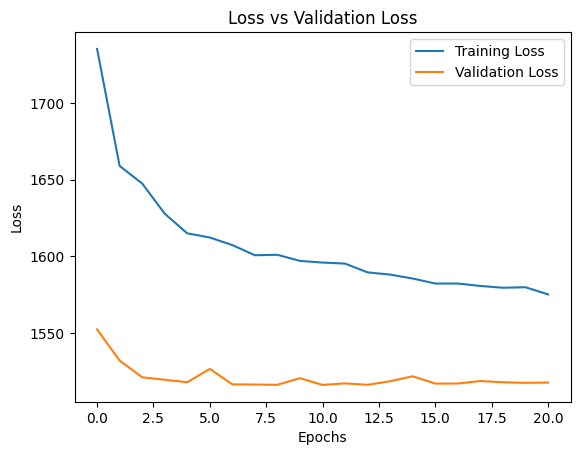

In [379]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

On fais de la feature importance afind de savoir quel sont les features avec le plus d'impact

1875/1875 [==============================] - 1s 788us/step
              Feature  Importance
8                wCap    0.948621
0               Brand    0.201500
7               Color    0.193486
3        Compartments    0.170580
2                Size    0.084300
5          Waterproof    0.062953
4  Laptop Compartment    0.055555
1            Material    0.033224
6               Style   -0.011057


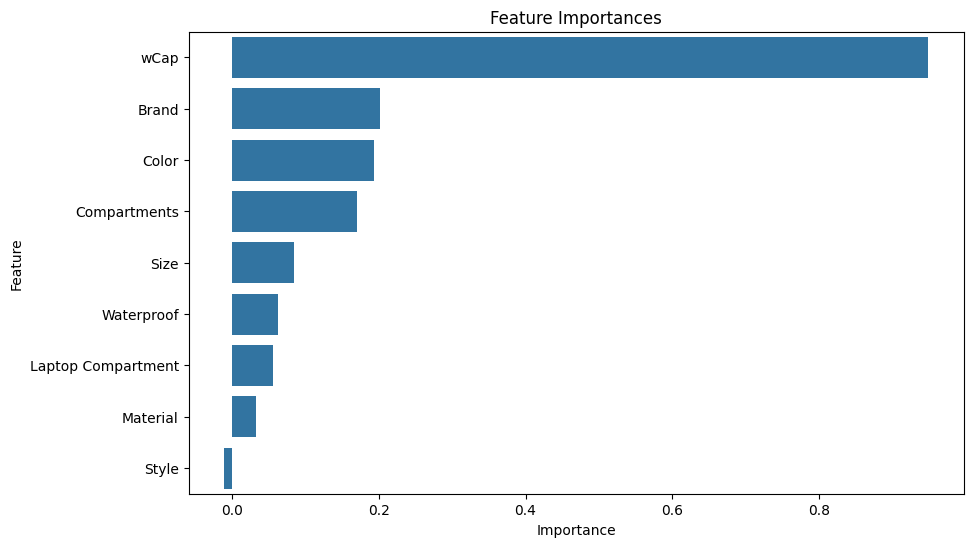

In [380]:
from sklearn.inspection import permutation_importance

y_pred = model.predict(X_val)

result = permutation_importance(model, X_val, y_val, n_repeats=10, random_state=42, scoring='neg_mean_squared_error')
feature_importances = result.importances_mean

feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print(feature_importance_df)
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances')
plt.show()

In [381]:
X_train.dtypes

Brand                   int32
Material                int32
Size                    int32
Compartments          float64
Laptop Compartment      int32
Waterproof              int32
Style                   int32
Color                   int32
wCap                  float64
dtype: object

In [382]:
y_train.dtypes

dtype('float64')

In [383]:
X_train.shape

(240000, 9)

# Model

In [ ]:

from tensorflow.keras.optimizers import Adam



Cnn_model = Sequential([
    layers.Reshape((X_train.shape[1], 1), input_shape=(X_train.shape[1],)),
    layers.Conv1D(64, 3, activation='relu', padding='same'),  
    layers.Dropout(0.2),
    layers.MaxPooling1D(2),
    layers.Conv1D(32, 3, activation='relu', padding='same'),
    layers.MaxPooling1D(2),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
])

#Version Optuna 

# Cnn_model = Sequential([
#     layers.Reshape((X_train.shape[1], 1), input_shape=(X_train.shape[1],)),
#     layers.Conv1D(74, 4, activation='relu', padding='same'),
#     layers.Dropout(0.27037316940778766),
#     layers.MaxPooling1D(2),
#     layers.Conv1D(22, 5, activation='relu', padding='same'),
#     layers.MaxPooling1D(2),
#     layers.Dropout(0.4572760106271475),
#     layers.Flatten(),
#     layers.Dense(116, activation='relu'),
#     layers.Dense(1)
# ])

optimizer = Adam(learning_rate=5.473748811058566e-05)
Cnn_model.compile(optimizer=optimizer, loss='mean_squared_error')


Cnn_model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
Cnn_model.summary()

cnn_history = Cnn_model.fit(X_train, y_train, 
                    validation_data=(X_val, y_val),
                    epochs=100, 
                    batch_size=32,
                    callbacks=[early_stopping])

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_18 (Reshape)        (None, 9, 1)              0         
                                                                 
 conv1d_36 (Conv1D)          (None, 9, 74)             370       
                                                                 
 dropout_44 (Dropout)        (None, 9, 74)             0         
                                                                 
 max_pooling1d_36 (MaxPooli  (None, 4, 74)             0         
 ng1D)                                                           
                                                                 
 conv1d_37 (Conv1D)          (None, 4, 22)             8162      
                                                                 
 max_pooling1d_37 (MaxPooli  (None, 2, 22)             0         
 ng1D)                                               

Loss vs Val_loss CNN

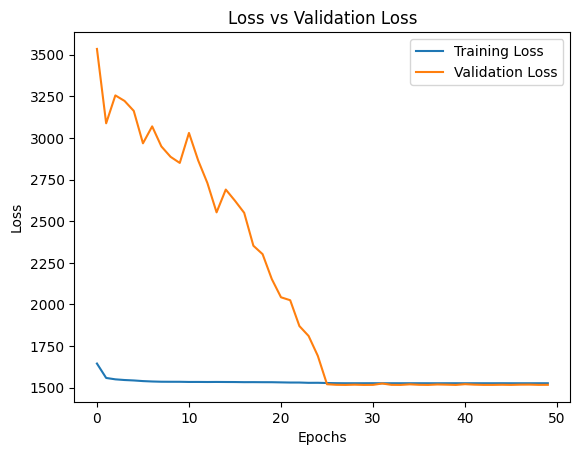

In [387]:
plt.plot(cnn_history.history['loss'], label='Training Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

TRES ETRANGE ? 

In [388]:
Cnn_model.save('cnn_optuned.h5')

c:\Users\gerar\Desktop\Project_sc\Challenge\.venv\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Feature Importance pour le Cnn

Kaggle sub